# Import libraries

In [5]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tslearn.clustering import TimeSeriesKMeans

from sklearn.metrics import silhouette_score

from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [6]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

# Loading data

In [7]:
path_to_data = './../../data/ftir_data/ftir_scaled.csv'
path_to_description = './../../data/ftir_data/ftir_description.csv'

In [8]:
# reading data
data_scaled = pd.read_csv(path_to_data)

# setting indexes
data_scaled.index = data_scaled.iloc[:, 0].tolist()
data_scaled.index.values[1:] = data_scaled.index.values[1:].astype(int)

# deleting useless column
if 'Unnamed: 0' in data_scaled.columns:
    data_scaled = data_scaled.drop(columns=['Unnamed: 0'])

data_scaled.head(3)

0            1            2            3            4  \
wavenumber  1900.766600  1899.802230  1898.837870  1897.873500  1896.909130   
1              0.000494     0.000944     0.001362     0.001750     0.002112   
2              0.000210     0.000215     0.000213     0.000205     0.000192   

                      5            6            7            8            9  \
wavenumber  1895.944770  1894.980400  1894.016030  1893.051670  1892.087300   
1              0.002451     0.002770     0.003074     0.003364     0.003646   
2              0.000175     0.000155     0.000132     0.000109     0.000085   

                     10           11           12           13           14  \
wavenumber  1891.122930  1890.158570  1889.194200  1888.229830  1887.265470   
1              0.003921     0.004193     0.004467     0.004744     0.005028   
2              0.000063     0.000042     0.000025     0.000011     0.000003   

                     15           16           17           18          19  \
wavenumber  1886.301100  1885.336730  1884.372370  1883.408000  1882.44364   
1              0.005324     0.005633     0.005960     0.006308     0.00668   
2              0.000000     0.000004     0.000017     0.000039     0.00007   

                     20           21           22           23           24  \
wavenumber  1881.479270  1880.514900  1879.550540  1878.586170  1877.621800   
1              0.007079     0.007509     0.007974     0.008476     0.009019   
2              0.000113     0.000168     0.000236     0.000318     0.000415   

            ...        1117        1118        1119        1120        1121  \
wavenumber  ...  823.569090  822.604720  821.640360  820.675990  819.711620   
1           ...    0.037121    0.035323    0.033560    0.031835    0.030152   
2           ...    0.072690    0.071565    0.070364    0.069083    0.067721   

                  1122        1123        1124        1125        1126  \
wavenumber  818.747260  817.782890  816.818520  815.854160  814.889790   
1             0.028514    0.026926    0.025390    0.023910    0.022491   
2             0.066275    0.064743    0.063123    0.061413    0.059610   

                  1127        1128        1129        1130        1131  \
wavenumber  813.925420  812.961060  811.996690  811.032320  810.067960   
1             0.021135    0.019846    0.018627    0.017483    0.016417   
2             0.057713    0.055719    0.053626    0.051432    0.049135   

                  1132        1133        1134        1135        1136  \
wavenumber  809.103590  808.139230  807.174860  806.210490  805.246130   
1             0.015433    0.014533    0.013723    0.013004    0.012382   
2             0.046732    0.044221    0.041600    0.038868    0.036021   

                  1137        1138        1139        1140        1141  
wavenumber  804.281760  803.317390  802.353030  801.388660  800.424290  
1             0.011859    0.011440    0.011127    0.010924    0.010836  
2             0.033058    0.029976    0.026773    0.023447    0.019997  

[3 rows x 1142 columns]

In [9]:
# reading data
samples_description = pd.read_csv(path_to_description)

# setting indexes
samples_description.index = samples_description.iloc[:, 0].tolist()
samples_description.index.values[1:] = samples_description.index.values[1:].astype(int)

# deleting useless column
if 'Unnamed: 0' in samples_description.columns:
    samples_description = samples_description.drop(columns=['Unnamed: 0'])

samples_description.head(3)

Description  Type  Class
1                    MFGO, разб. 1:20  $GO$      1
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1

In [10]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

In [11]:
type_color_dict = {
    'GO': 'dodgerblue',
    '$GO': 'orange',
    'GOd$': 'green'
}

# Clustering

## Class for clustering

In [12]:
class ClusterStructureAnalysis():
    def __init__(self, metric='euclidean'):
        self.metric = metric

    def fit_transform_ts_kmeans(self, train_data, n_clusters, n_jobs=25, max_iter=100_000, random_state=42):
        metric = self.metric
        estimator = TimeSeriesKMeans(n_clusters=n_clusters,
                                     metric=metric,
                                     n_jobs=n_jobs,
                                     max_iter=max_iter,
                                     random_state=random_state)
        
        estimator.fit(train_data)       
        
        self.n_clusters = n_clusters
        self.train_data = train_data
        self.estimator = estimator
        self.inertia = estimator.inertia_
        self.cluster_centers = estimator.cluster_centers_[:, :, 0]

        predictions = pd.DataFrame(estimator.predict(train_data), index=train_data.index, columns=['Prediction'])
        self.predictions = predictions['Prediction']
        self.train_data_predictions = pd.concat([train_data, predictions], axis=1)

    def get_silhouette_score(self):
        train_data = self.train_data
        estimator = self.estimator
        if self.n_clusters >= 2:
            silhouette = silhouette_score(train_data, estimator.labels_)
        else:
            silhouette = None
        return silhouette

    def get_inertia(self):
        inertia = self.inertia
        return inertia

    def get_metric_in_range(self, metric='silhouette', max_n_clusters=None):
        train_data = self.train_data
        if max_n_clusters is None:
            max_n_clusters = train_data.shape[0] // 2
        n_clusters_arr = range(2, max_n_clusters+1)


        metric_values = []
        for n_clusters in tqdm(n_clusters_arr):
            self.fit_transform_ts_kmeans(train_data=train_data, n_clusters=n_clusters)
            if metric == 'silhouette':
                value = self.get_silhouette_score()
            elif metric == 'inertia':
                value = self.get_inertia()
            metric_values.append(value)
        return metric_values

    def get_metrics_visualization(self, metric='silhouette', max_n_clusters=None, figsize=(11, 7.5), path_to_save=None, dpi=300):
        if max_n_clusters is None:
            max_n_clusters = self.train_data.shape[0] - 1
        
        n_clusters = list(range(2, max_n_clusters + 1))

        if metric == 'silhouette':
            metric_values = self.get_metric_in_range(metric='silhouette', max_n_clusters=max_n_clusters)
        elif metric == 'inertia':
            metric_values = self.get_metric_in_range(metric='inertia', max_n_clusters=max_n_clusters)

        qm_df_vis = pd.DataFrame(
            {
            'Number_of_clusters': n_clusters,
            'Value': metric_values
            }
        )
        
        sns.set_theme()

        fig = plt.figure(figsize=figsize, dpi=600, linewidth=1.0)
        
        ax = fig.gca()
        
        ax.grid(True)
        ax.tick_params(direction='in')
        
        bar = sns.barplot(data=qm_df_vis,
                          x='Number_of_clusters',
                          y='Value',
                          palette='mako',
                          ax=ax)
        
        ax.set_ylabel('Metric value',
                      fontstyle='normal',
                      fontsize=16,
                      rotation=90,
                      labelpad=5)
        
        ax.set_xlabel('Number of clusters',
                      fontstyle='normal',
                      fontsize=16,
                      rotation=0,
                      labelpad=5)
        
        bar.set_xticklabels(bar.get_xticklabels(), rotation=0, fontsize=16)
        
        plt.tight_layout()

        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

    def get_spectra_clusters_visualization(self, data, wavenumber, n_clusters, nrows, ncols, figsize=(10, 6), color='dodgerblue', path_to_save=None, dpi=300):
        self.fit_transform_ts_kmeans(train_data=data, n_clusters=n_clusters)
        data_with_labels = self.train_data_predictions
        centroids = self.cluster_centers

        fig = plt.figure(figsize=figsize, dpi=600)
        
        for i in range(n_clusters):
            temp_data = data_with_labels.loc[data_with_labels['Prediction'] == i].iloc[:, :-1].to_numpy()
            temp_centroid = centroids[i]
        
            ax = plt.subplot(nrows, ncols, i+1)
            
            for spectrum in temp_data:
                ax.plot(wavenumber, spectrum, linewidth=1.5, color=color)
        
            ax.plot(wavenumber, temp_centroid, linestyle='--', linewidth=2.0, color='black', label='Центроида')
        
            ax.set_xlabel('Волновое число, см$^{-1}$', fontstyle='normal', fontsize=12, labelpad=5)
            ax.set_ylabel('$A_{n}$', fontstyle='italic', fontsize=12, labelpad=15, rotation=0)
        
            ax.invert_xaxis()
        
            ax.legend()

        plt.tight_layout()
        
        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

## Metric — Euclidean distance

In [13]:
path_to_save = './../../results/ftir/clustering_spectra_as_timeseries/euclidean'

### *GO*

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 53.74it/s]


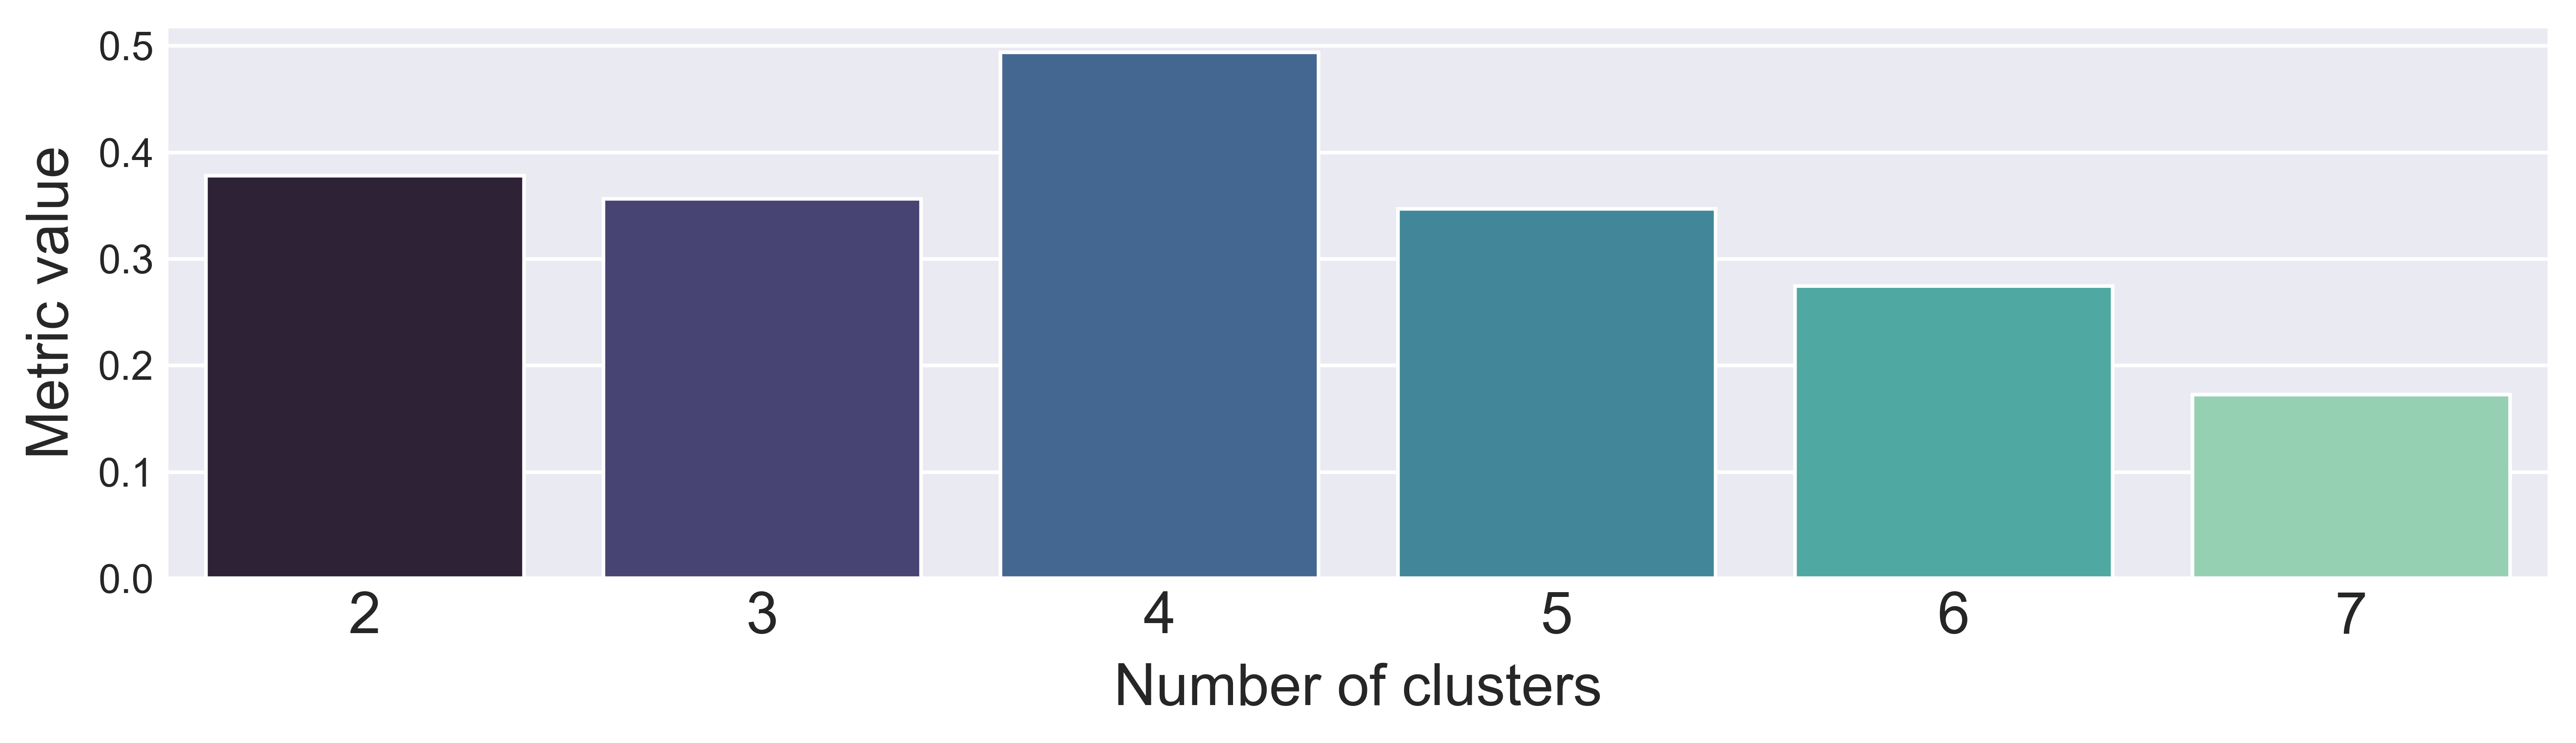

In [14]:
analyzer = ClusterStructureAnalysis(metric='euclidean')
analyzer.fit_transform_ts_kmeans(train_data=go_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/go_metrics.png', dpi=600)

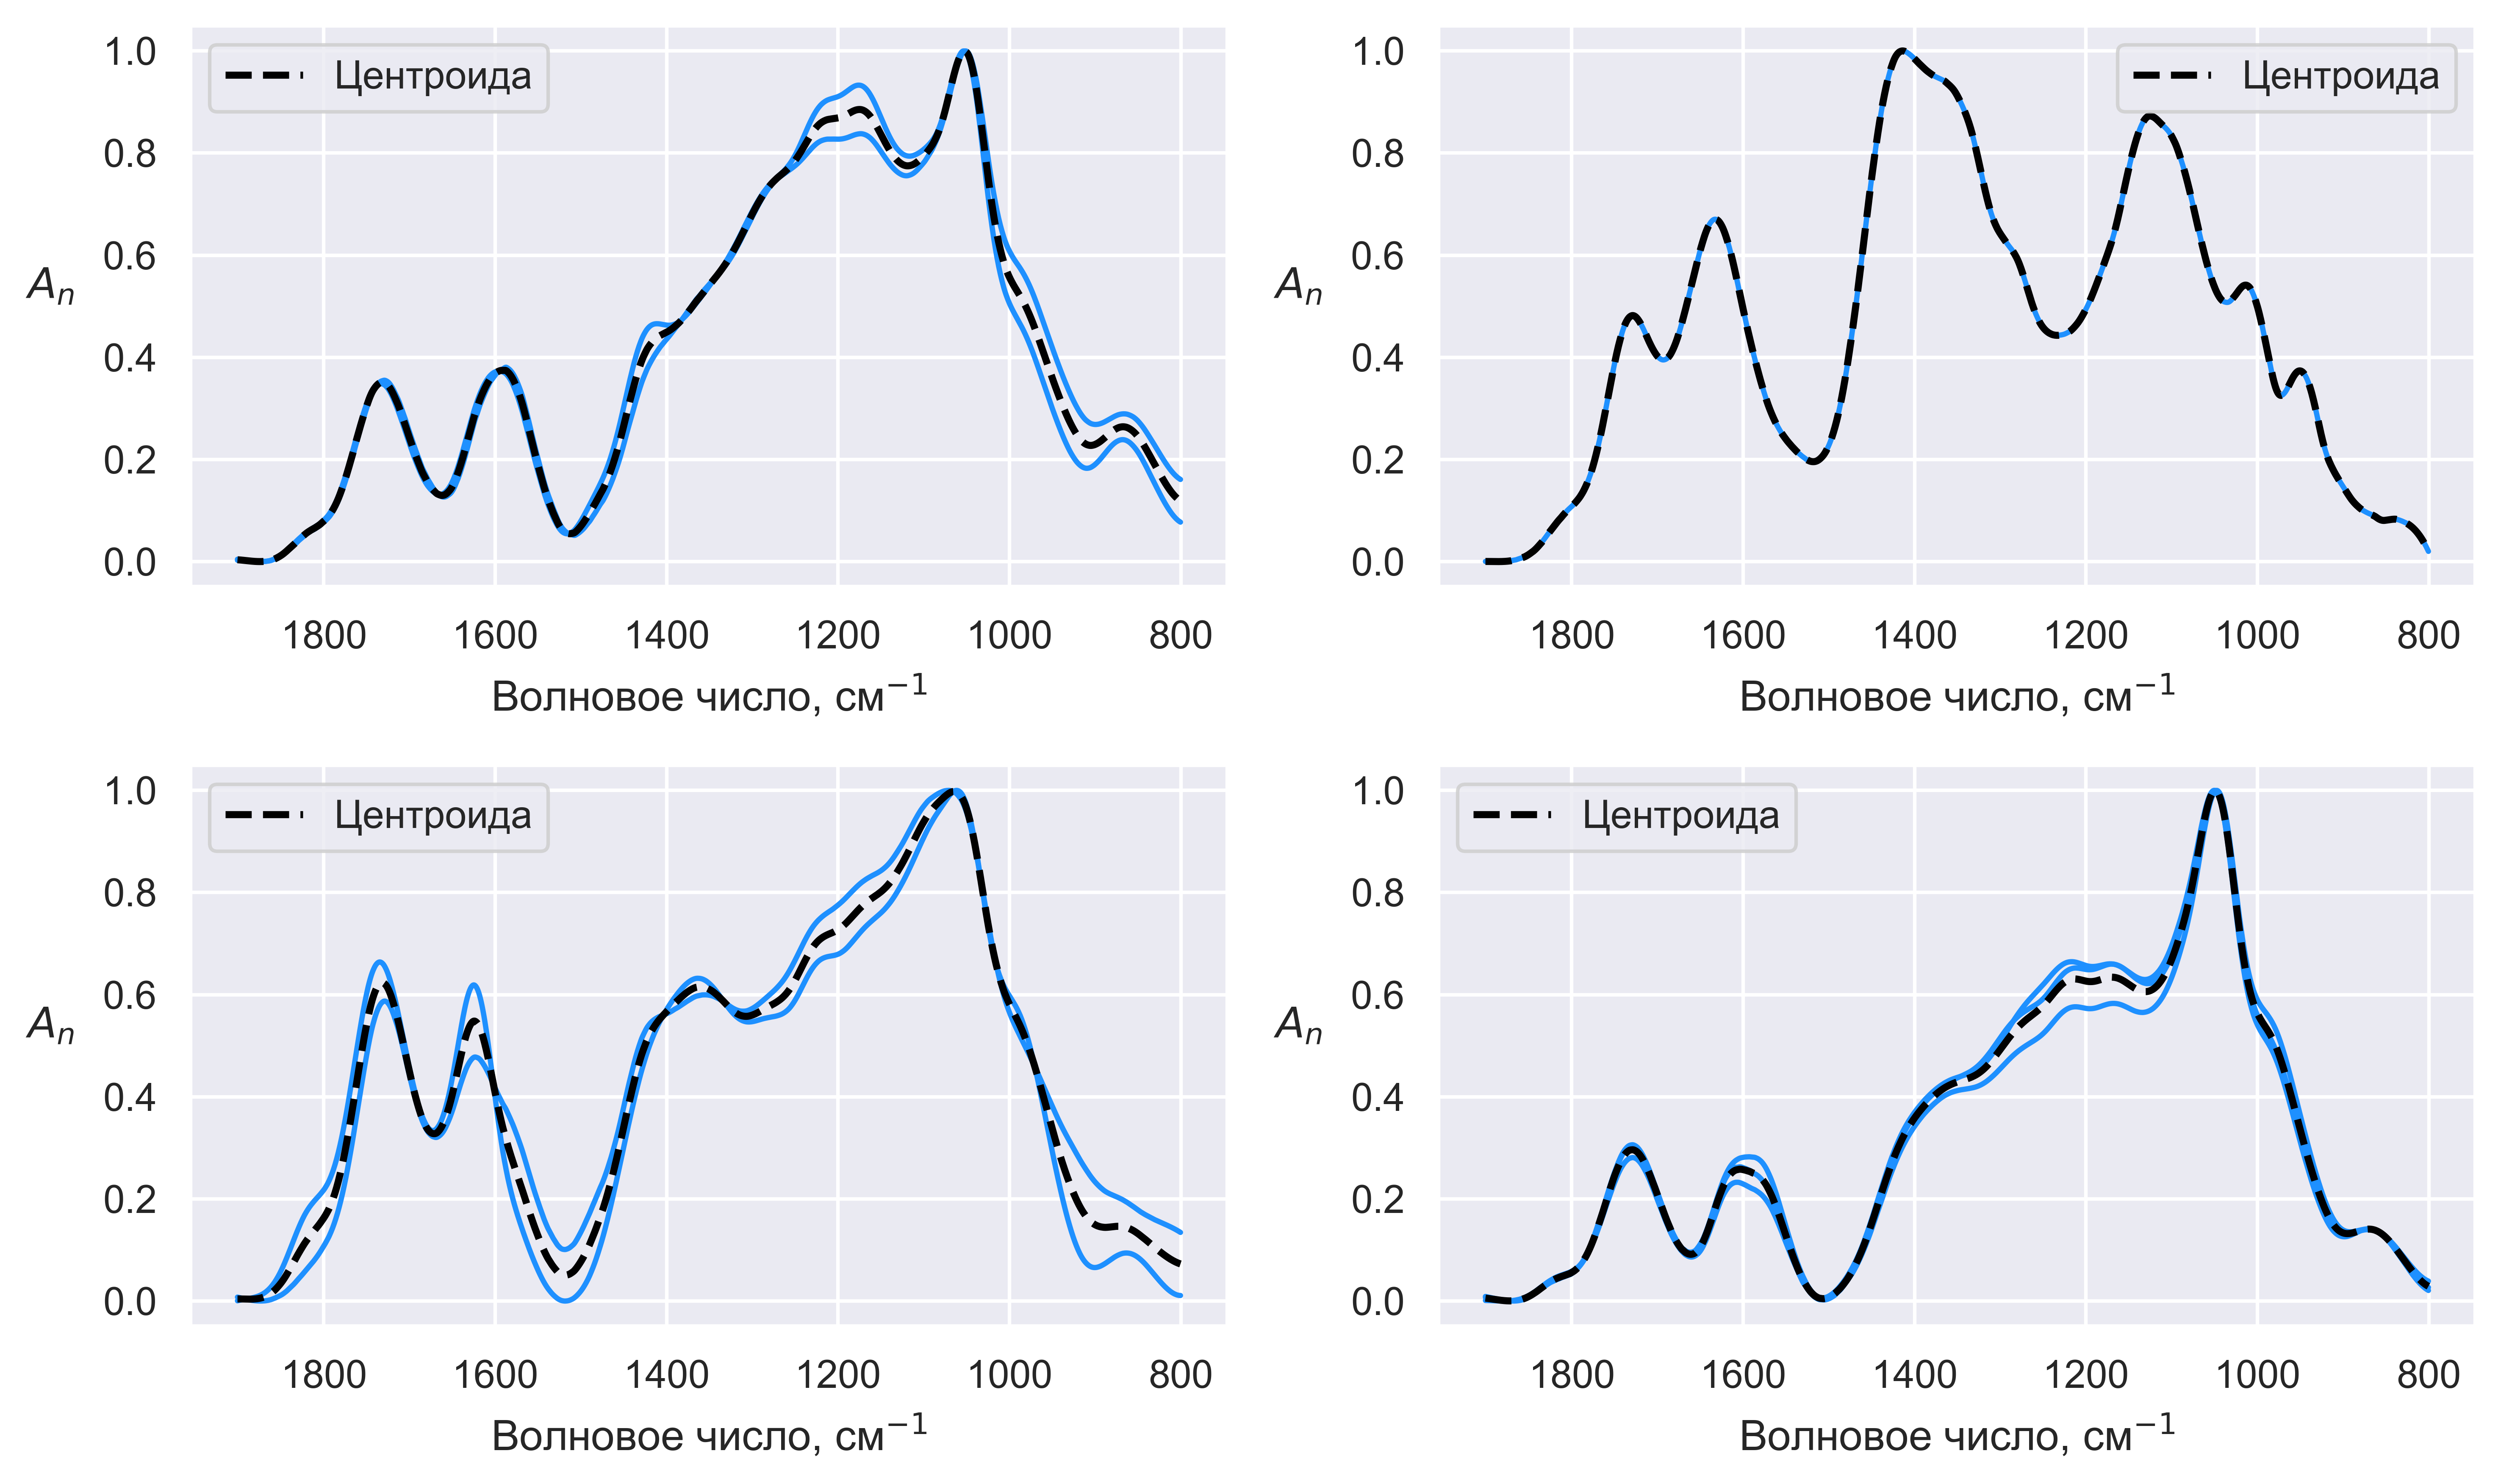

In [15]:
analyzer.get_spectra_clusters_visualization(data=go_data, wavenumber=wavenumber, n_clusters=4,
                                            ncols=2, nrows=2, figsize=(10, 6), color='dodgerblue',
                                            path_to_save=path_to_save + '/go_clusters.png', dpi=600)

### *rGO*

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.79it/s]


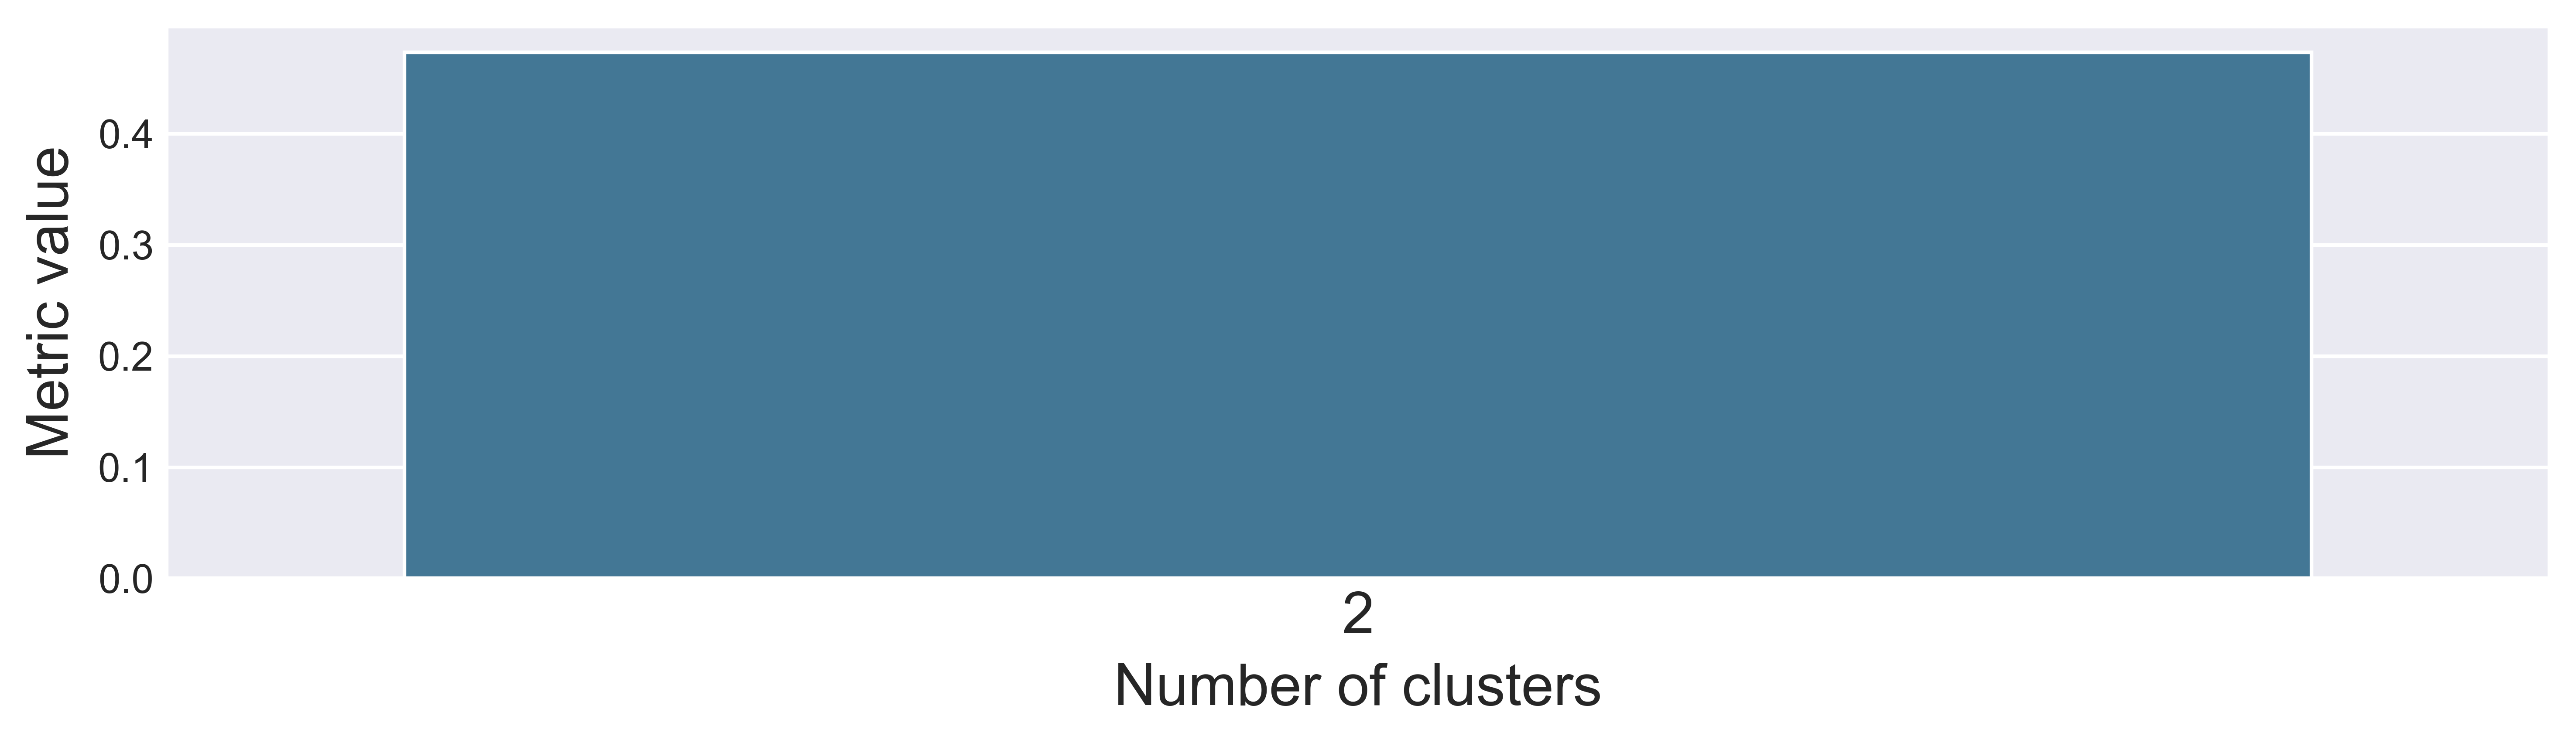

In [16]:
analyzer = ClusterStructureAnalysis(metric='euclidean')
analyzer.fit_transform_ts_kmeans(train_data=rgo_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/rgo_metrics.png', dpi=600)

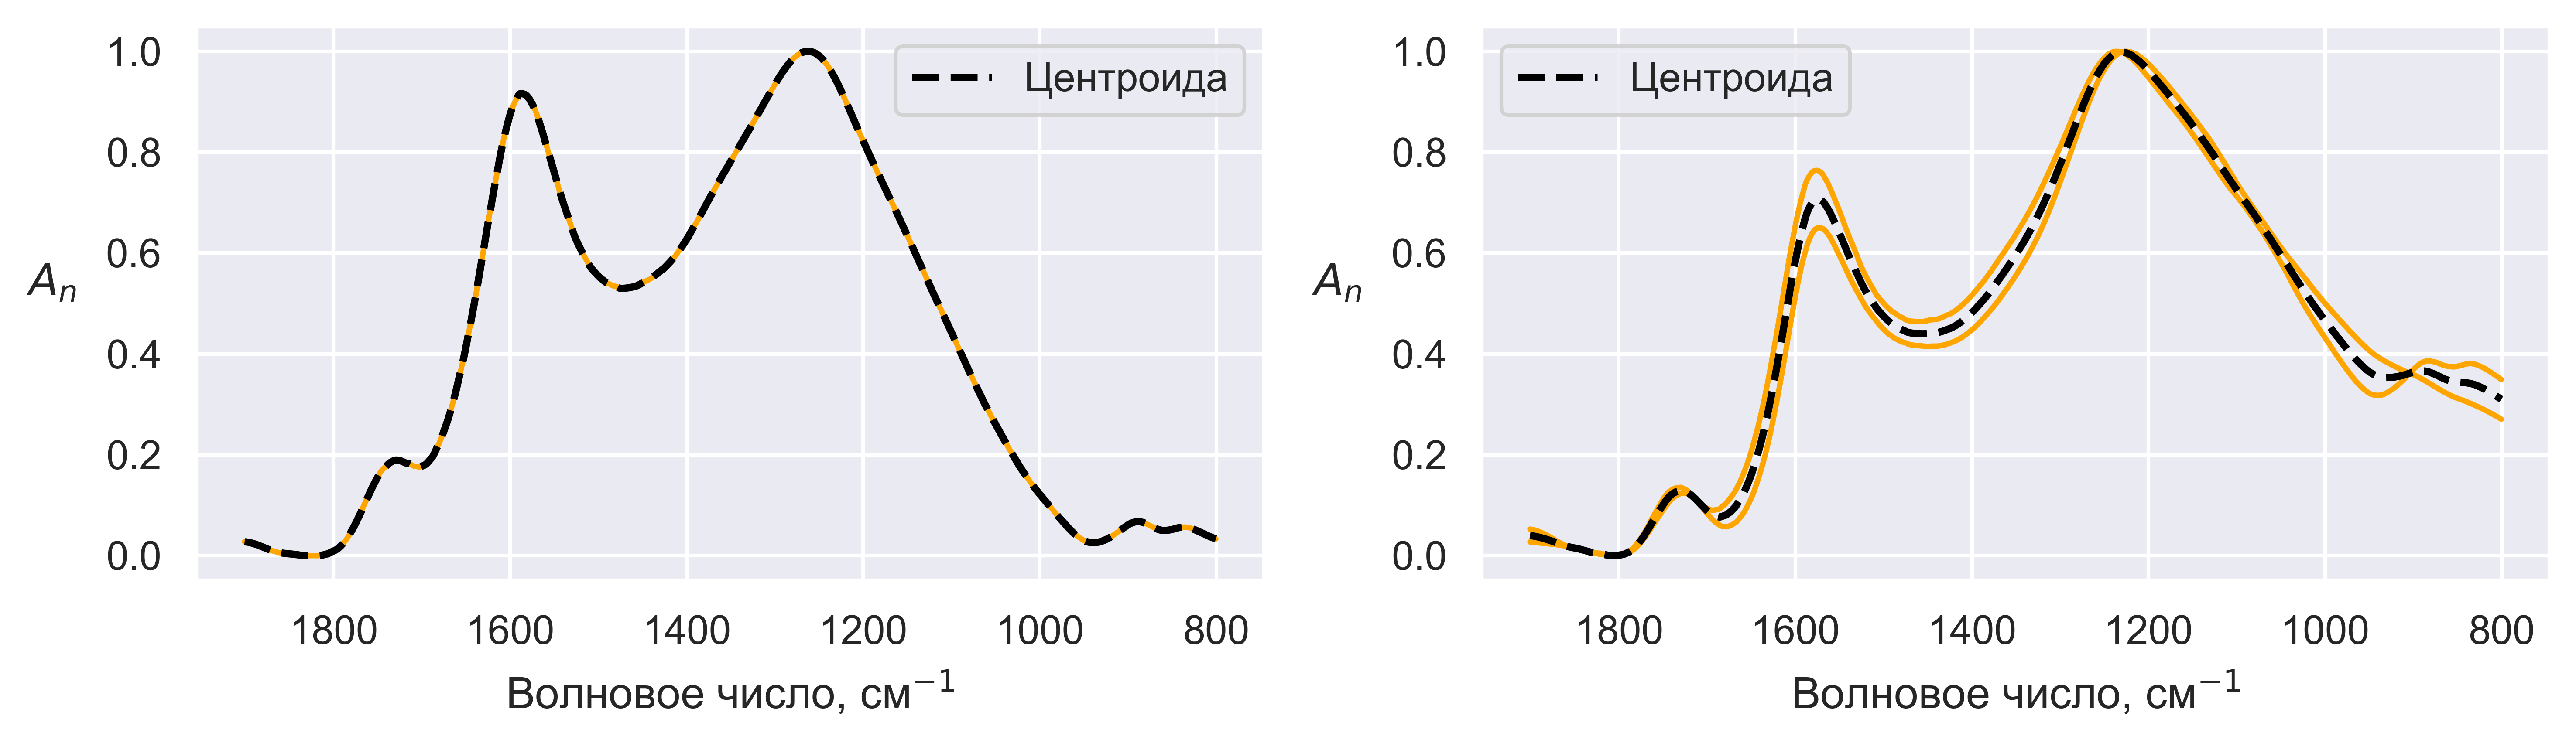

In [17]:
analyzer.get_spectra_clusters_visualization(data=rgo_data, wavenumber=wavenumber, n_clusters=2,
                                            ncols=2, nrows=1, figsize=(10, 3), color='orange',
                                            path_to_save=path_to_save + '/rgo_clusters.png', dpi=600)

### $GO_{d}$

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.13it/s]


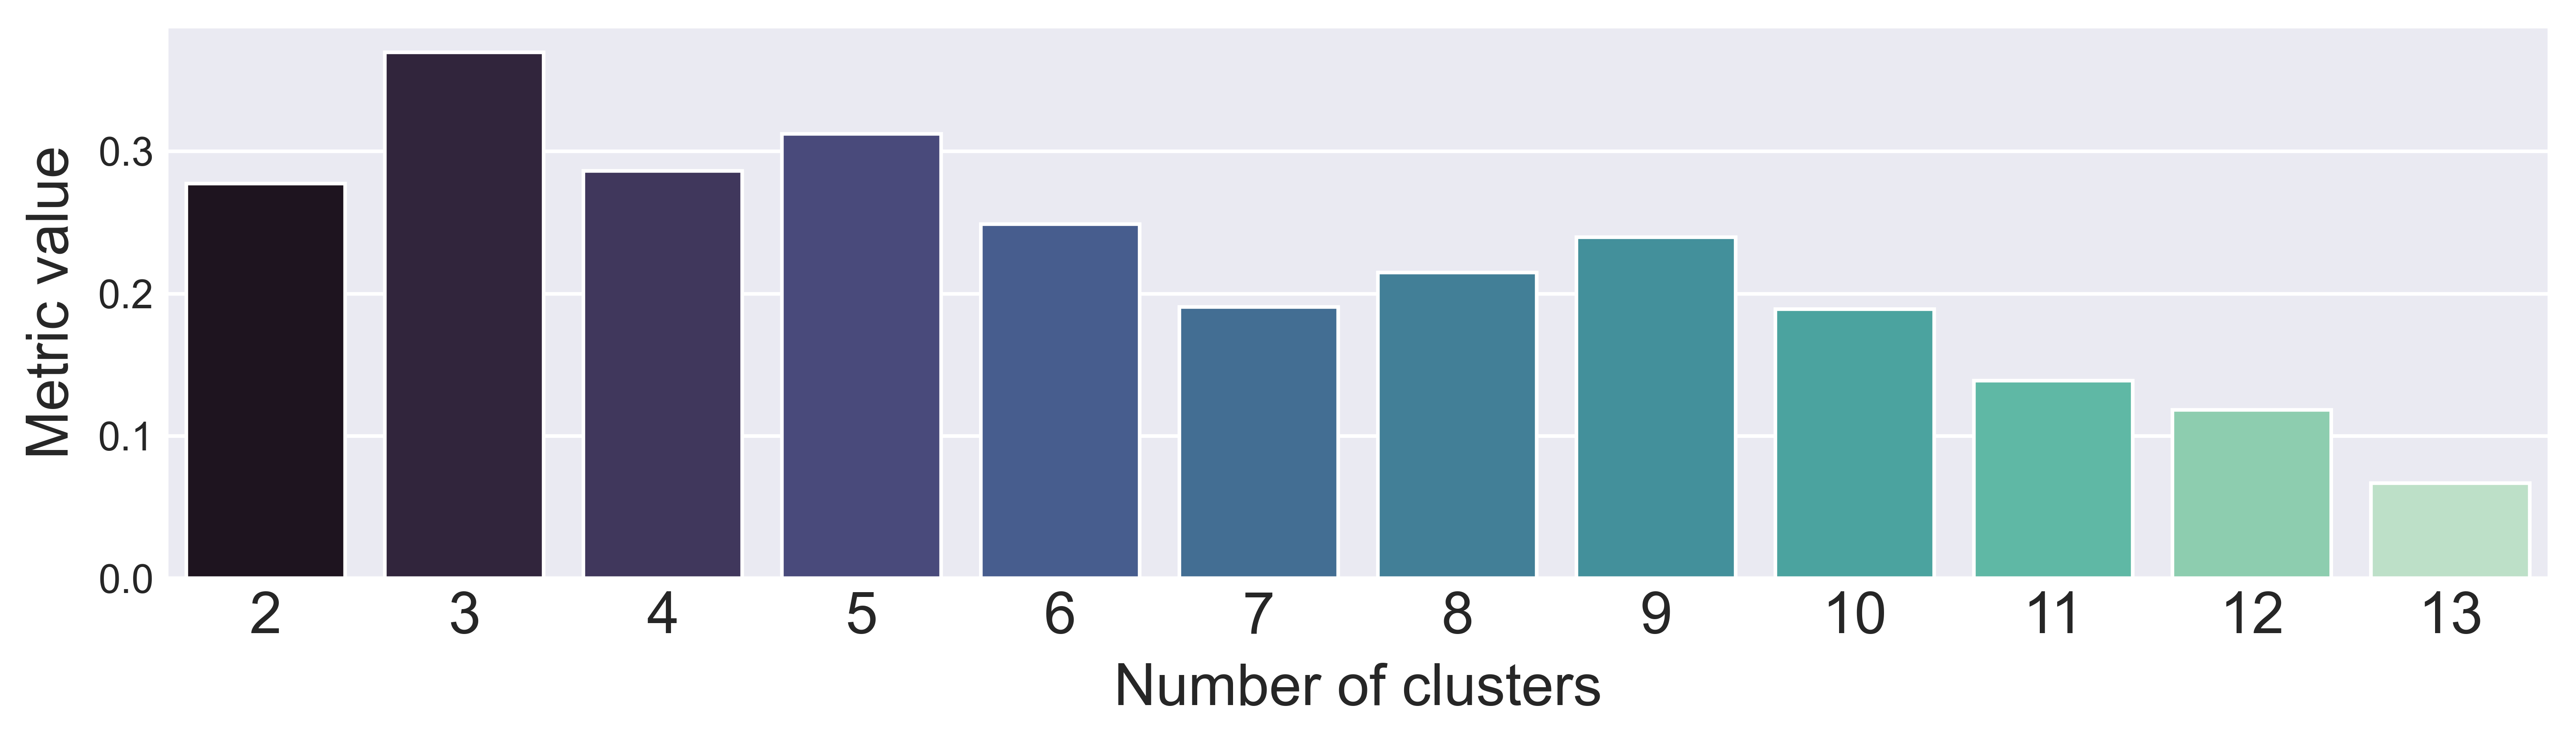

In [18]:
analyzer = ClusterStructureAnalysis(metric='euclidean')
analyzer.fit_transform_ts_kmeans(train_data=god_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/god_metrics.png', dpi=600)

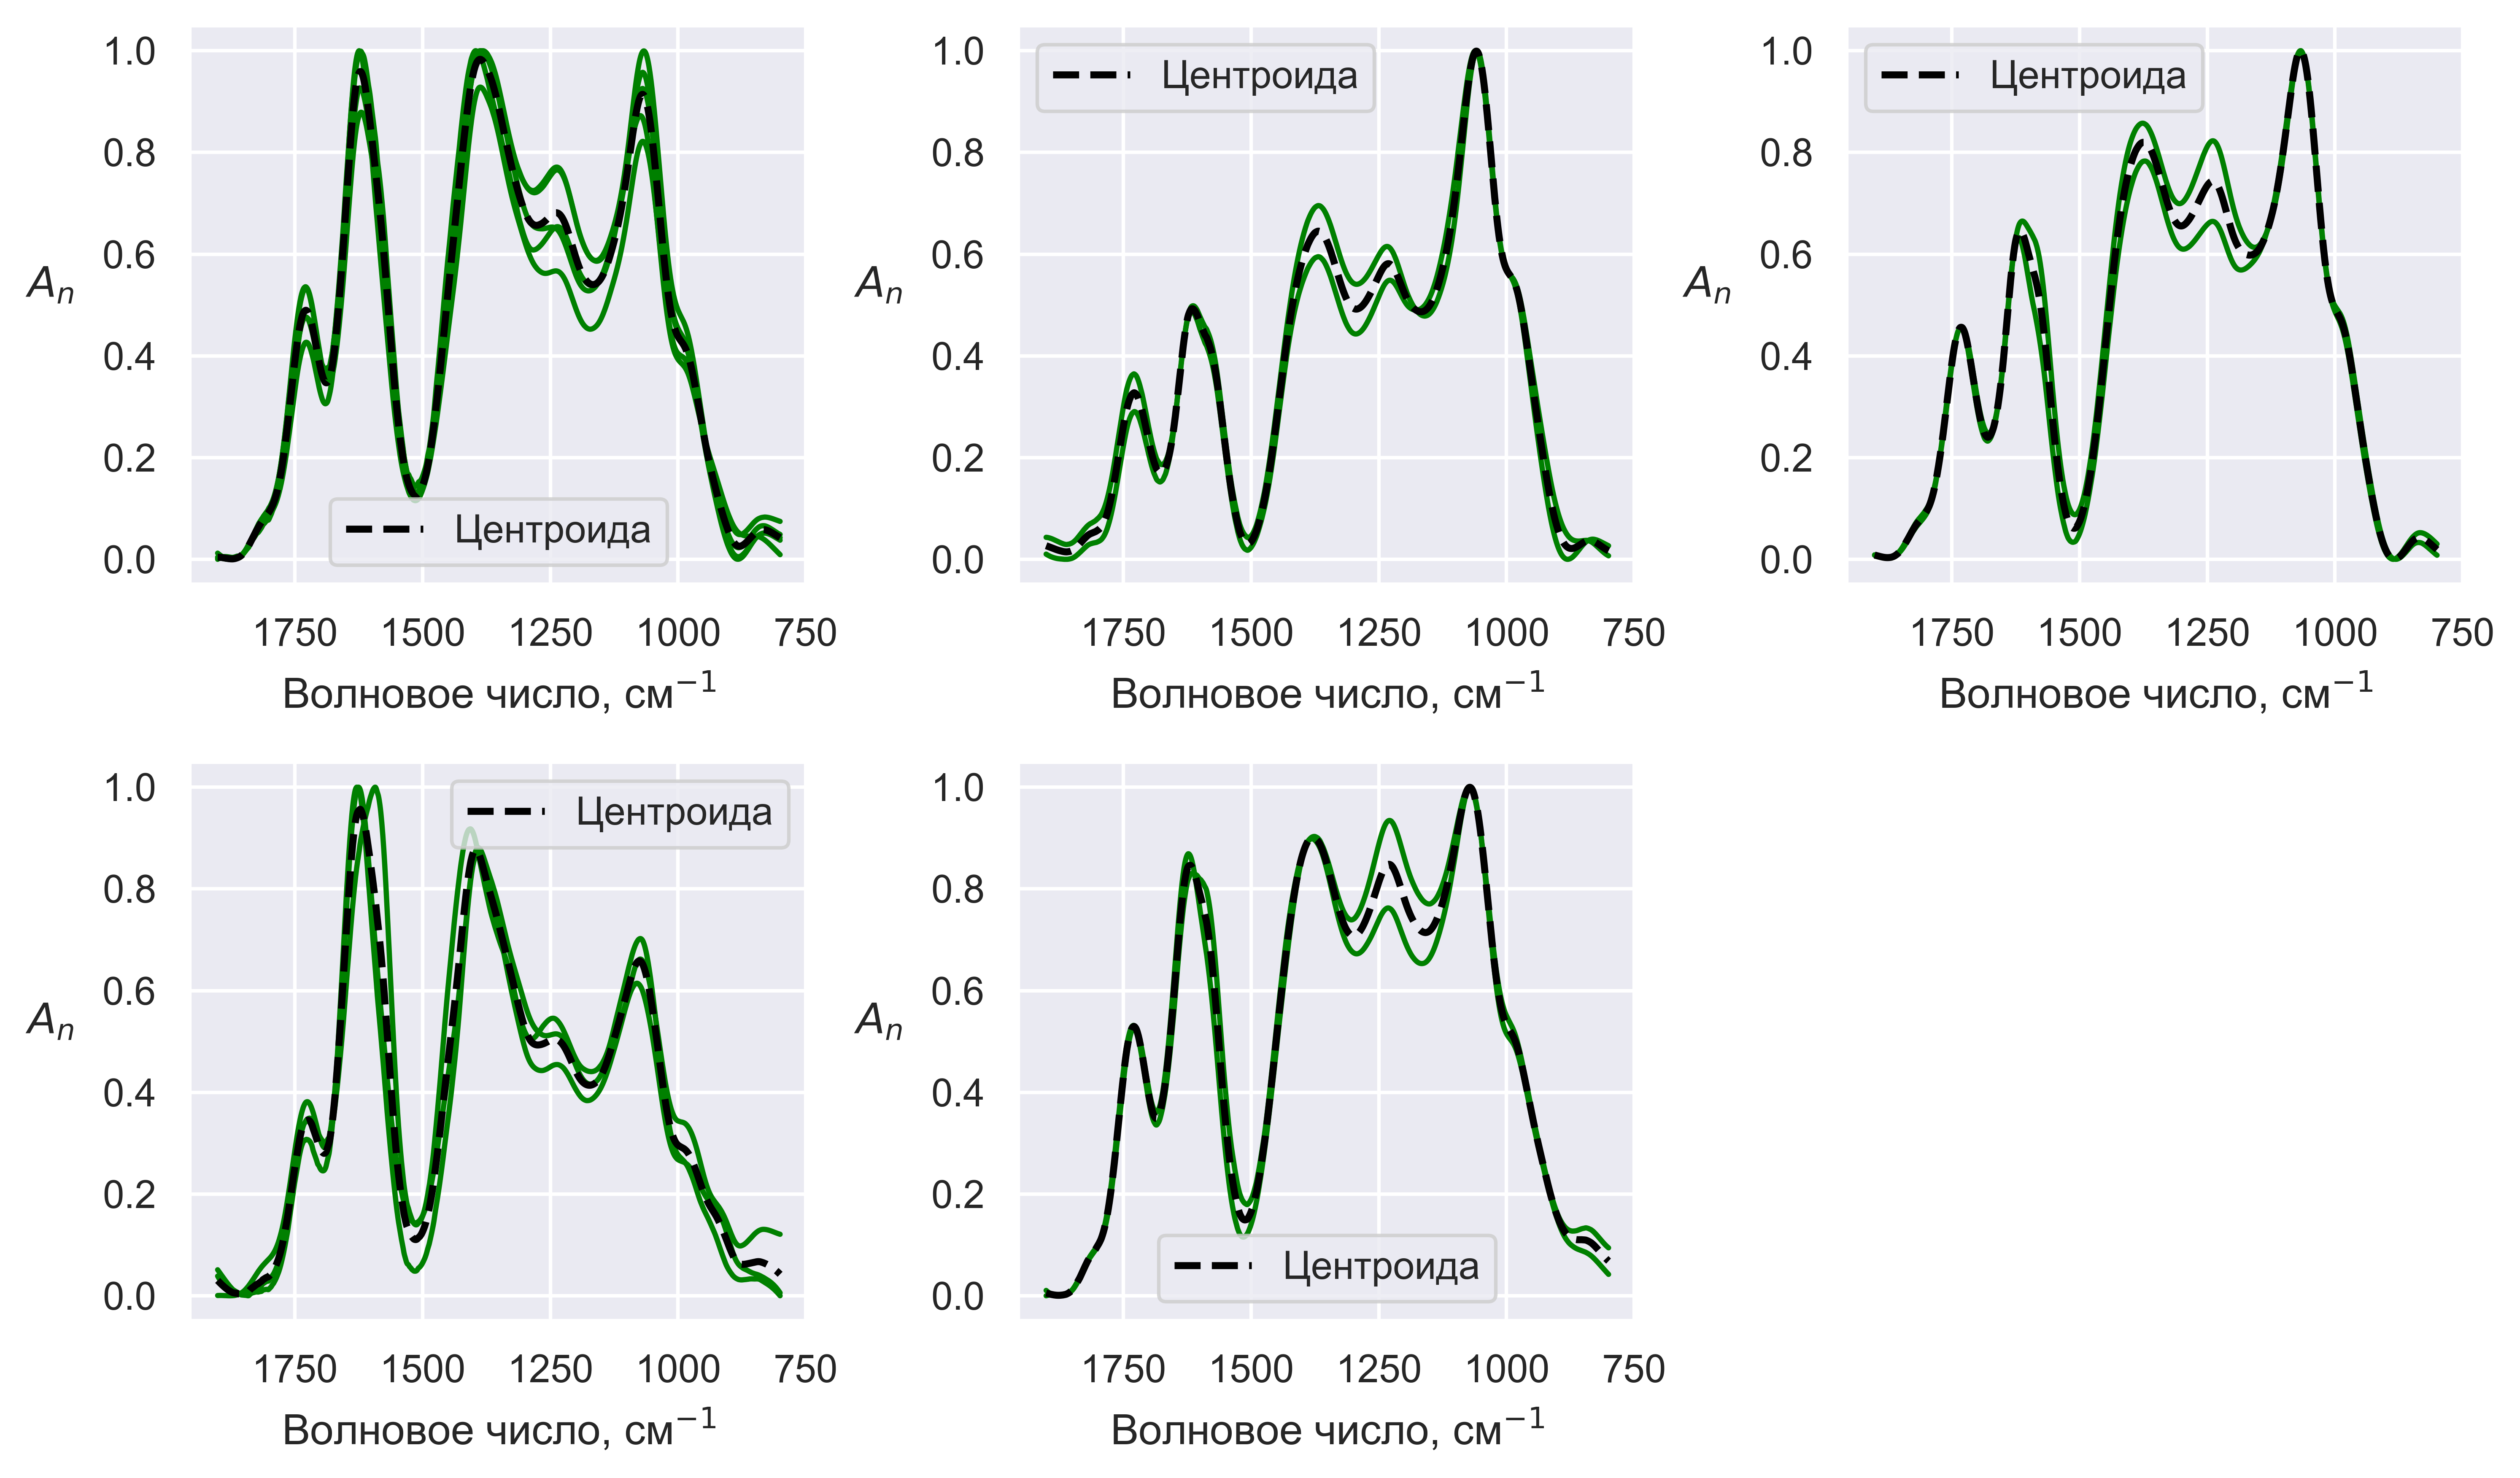

In [19]:
analyzer.get_spectra_clusters_visualization(data=god_data, wavenumber=wavenumber, n_clusters=5,
                                            ncols=3, nrows=2, figsize=(10, 6), color='green',
                                            path_to_save=path_to_save + '/god_clusters_5.png', dpi=600
                                           )

## Metric — DTW

In [20]:
path_to_save = './../../results/ftir/clustering_spectra_as_timeseries/dtw'

### *GO*

100%|███████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it]


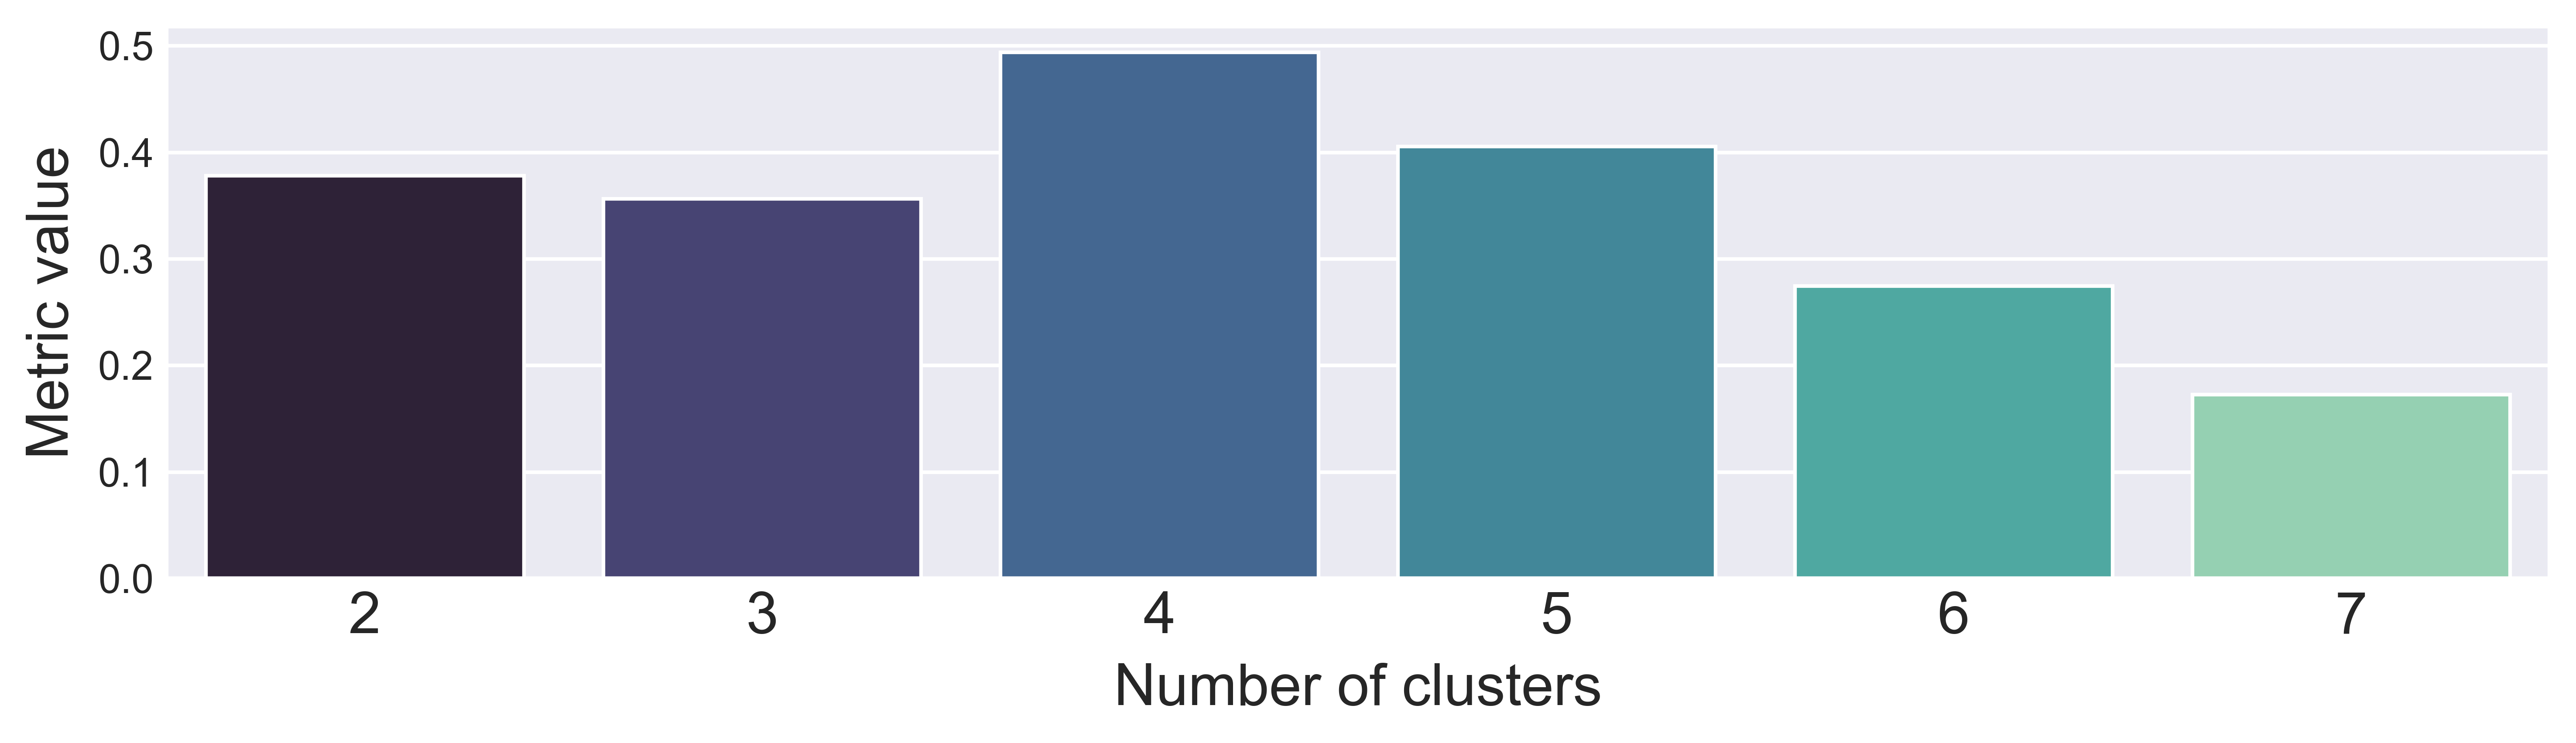

In [83]:
analyzer = ClusterStructureAnalysis(metric='dtw')
analyzer.fit_transform_ts_kmeans(train_data=go_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/go_metrics.png', dpi=600)

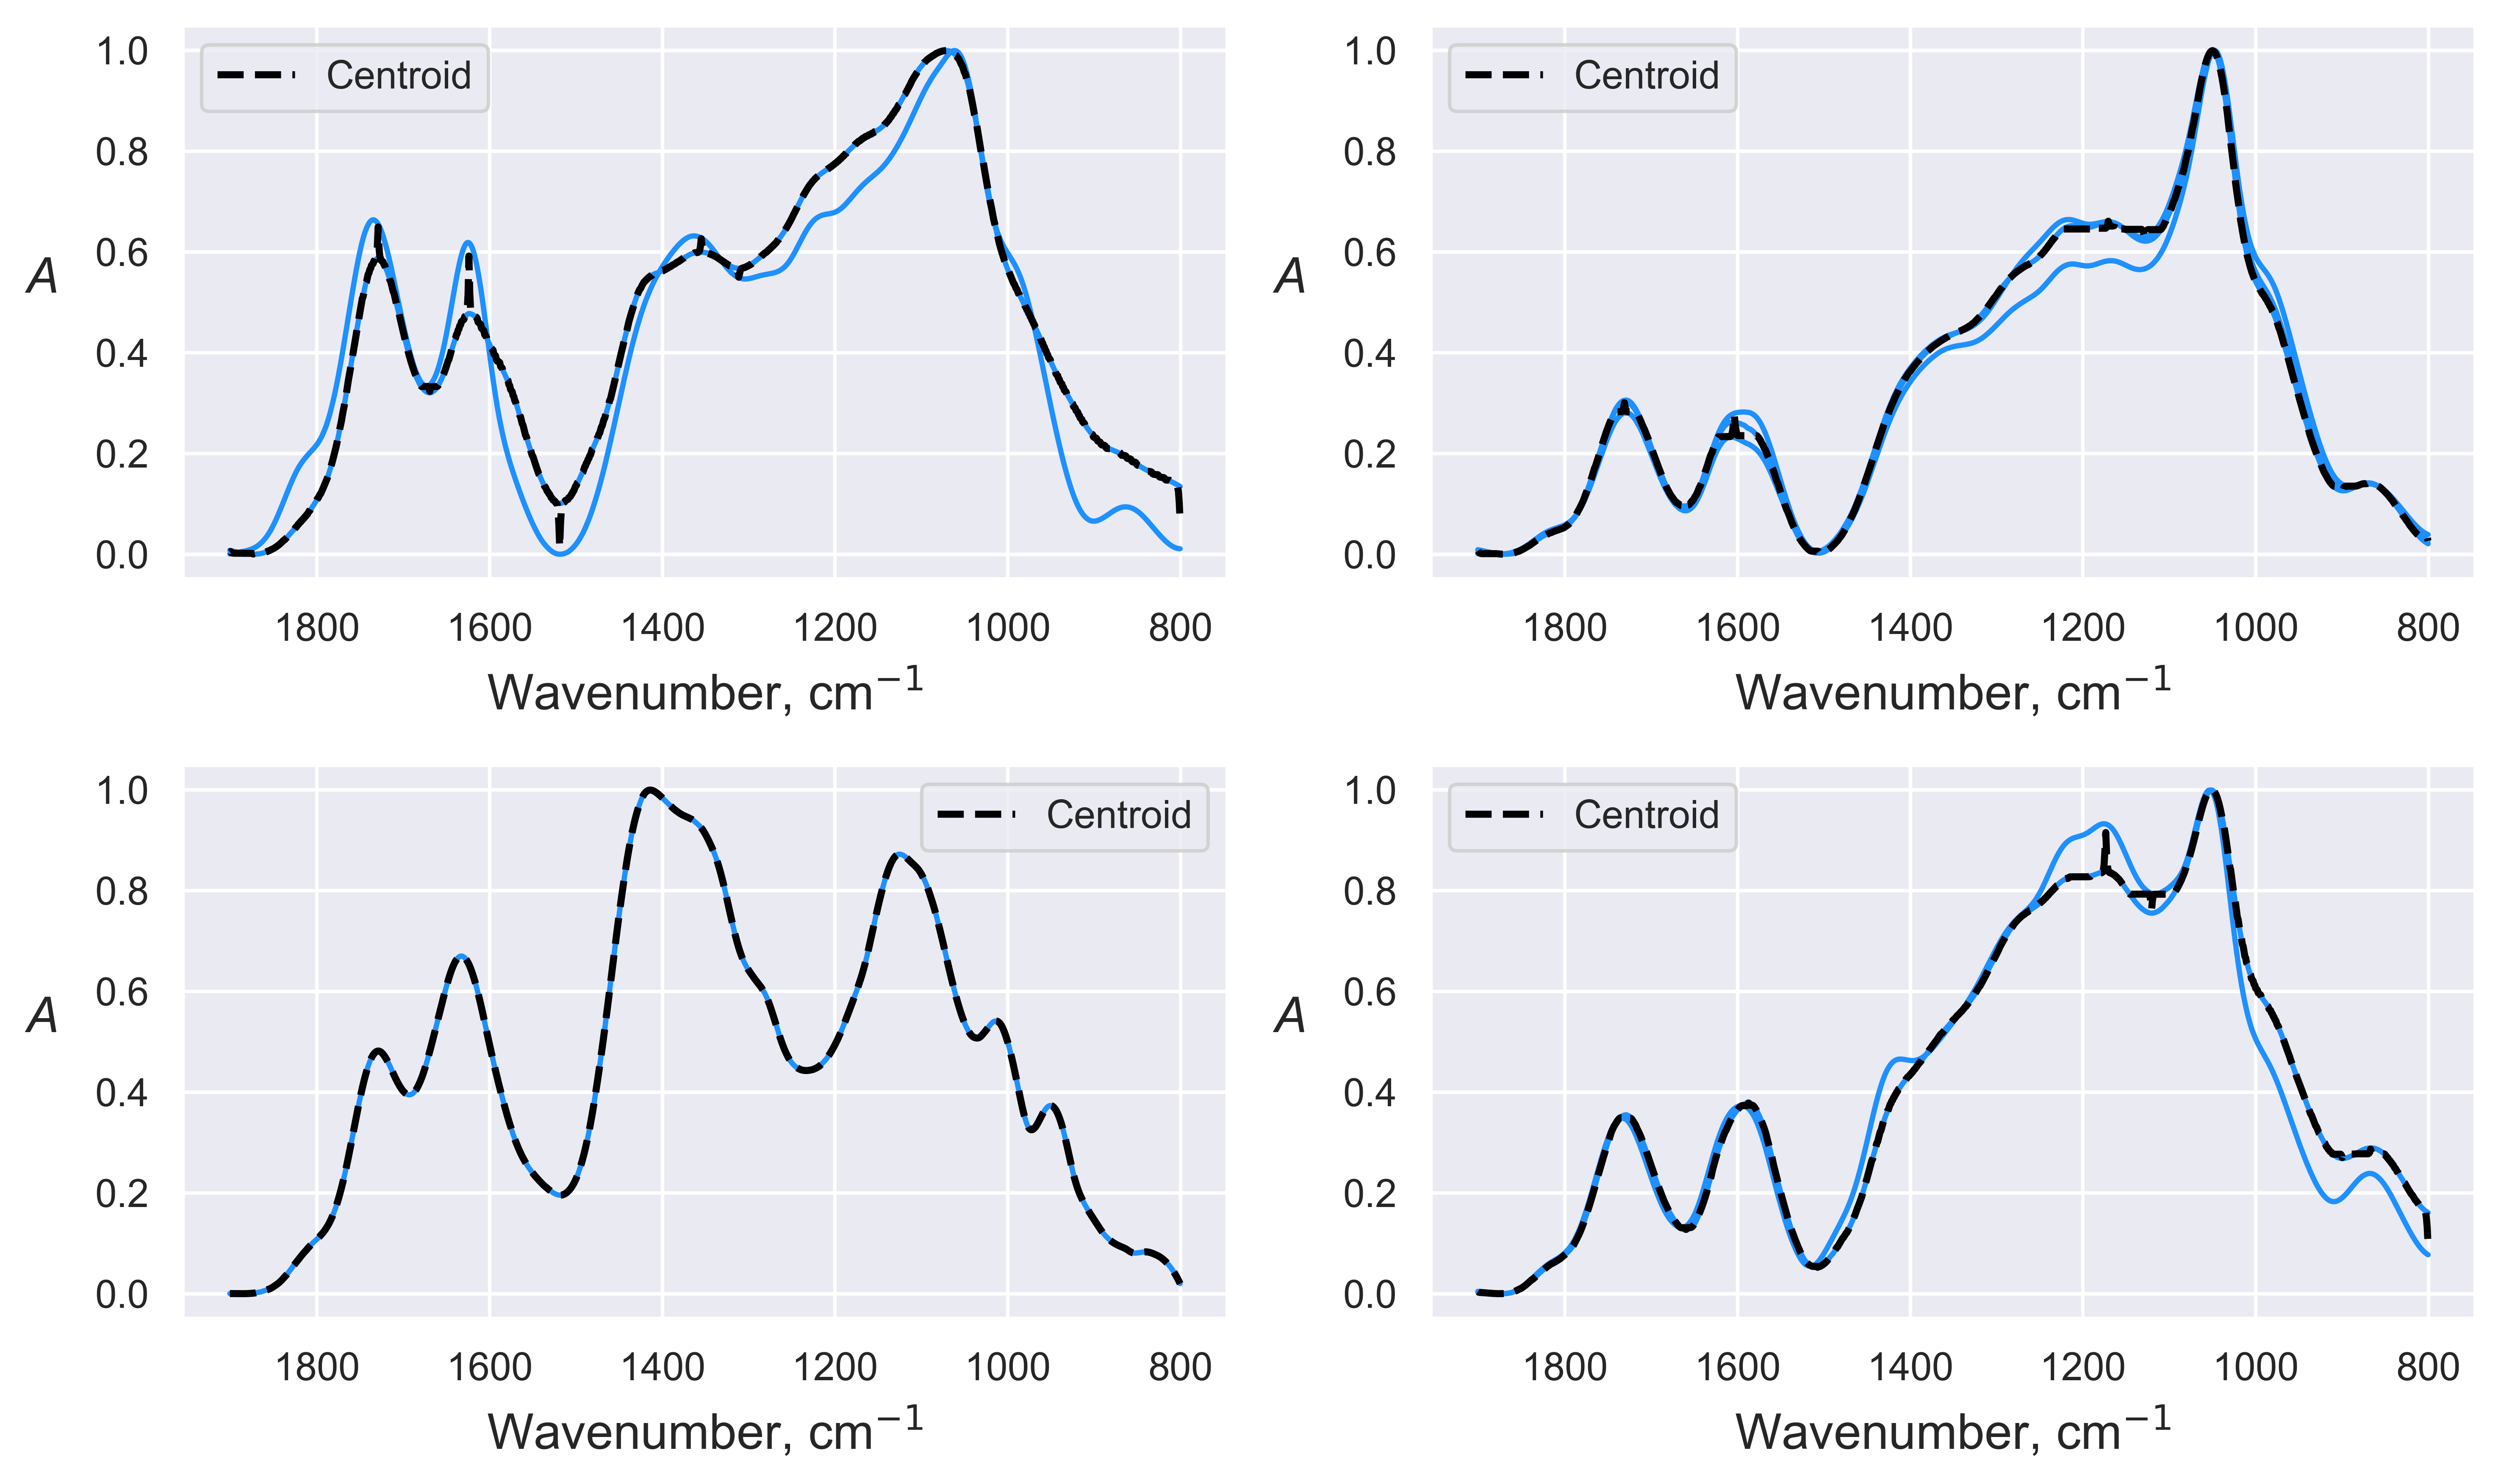

In [84]:
analyzer.get_spectra_clusters_visualization(data=go_data, wavenumber=wavenumber, n_clusters=4,
                                            ncols=2, nrows=2, figsize=(10, 6), color='dodgerblue',
                                            path_to_save=path_to_save + '/go_clusters.png', dpi=600)

### *rGO*

100%|███████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


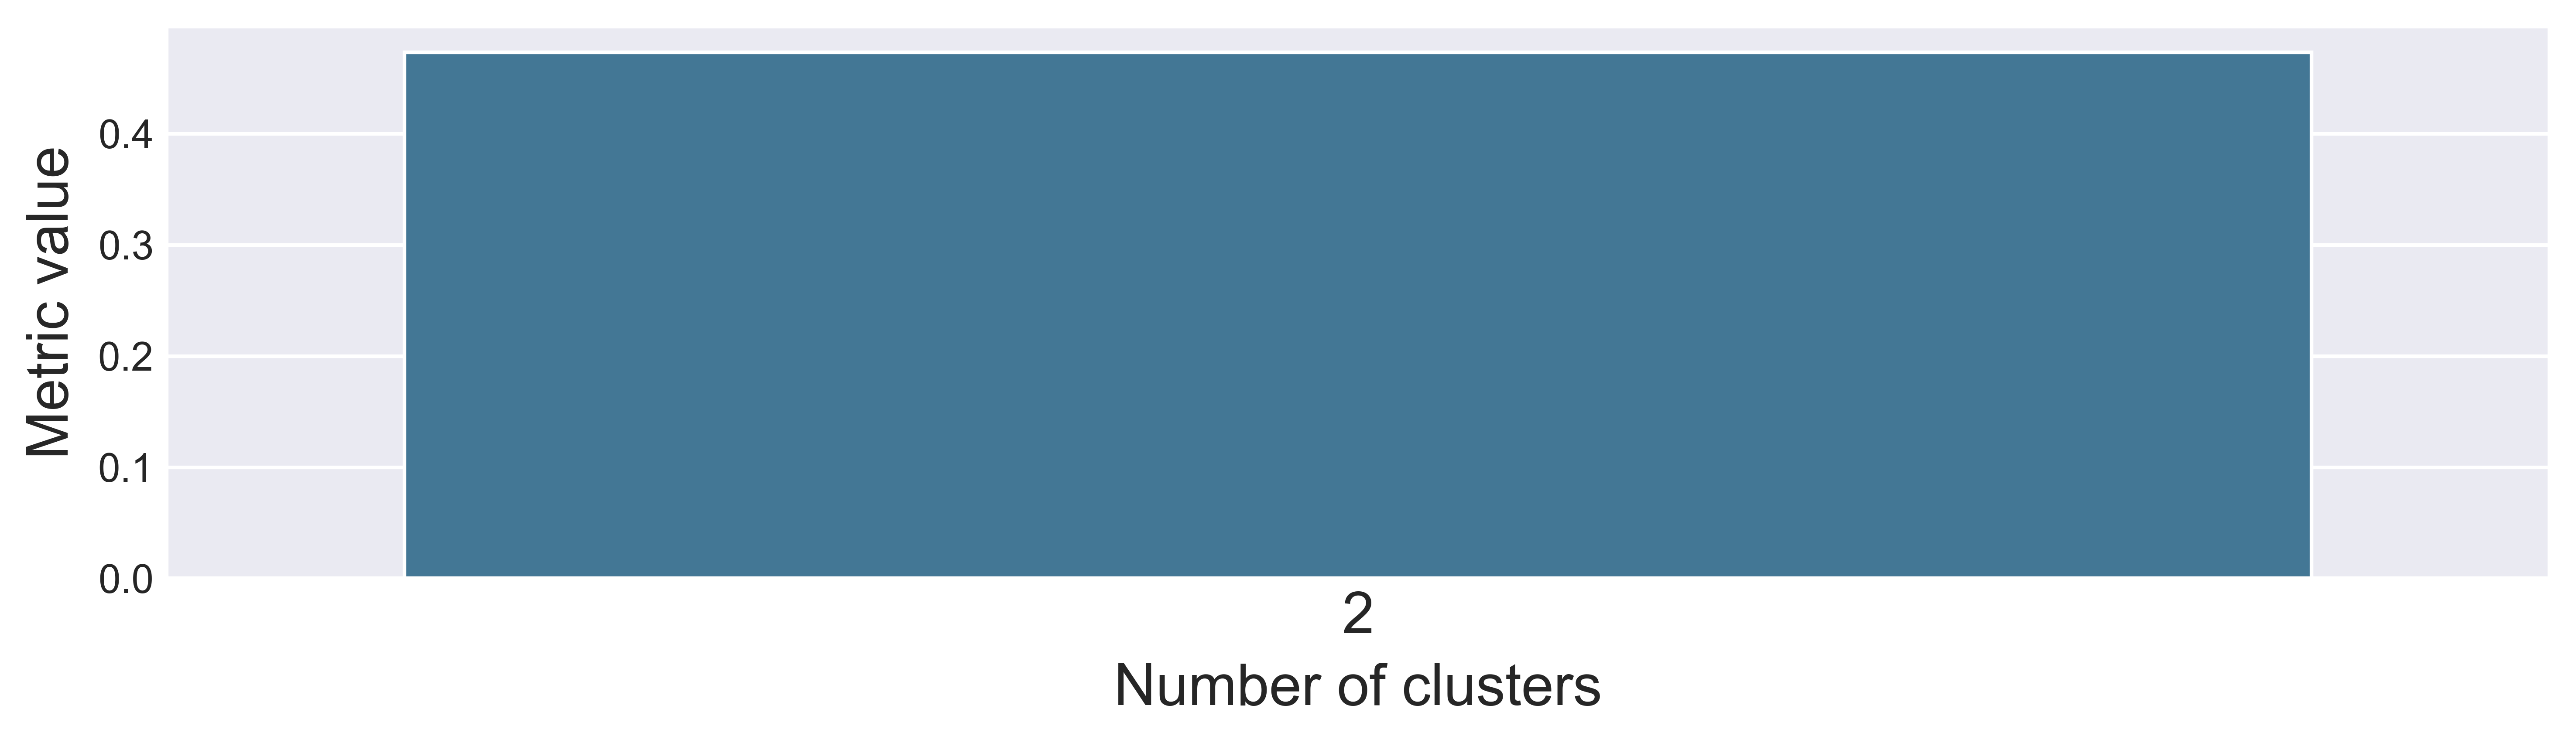

In [85]:
analyzer = ClusterStructureAnalysis(metric='dtw')
analyzer.fit_transform_ts_kmeans(train_data=rgo_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/rgo_metrics.png', dpi=600)

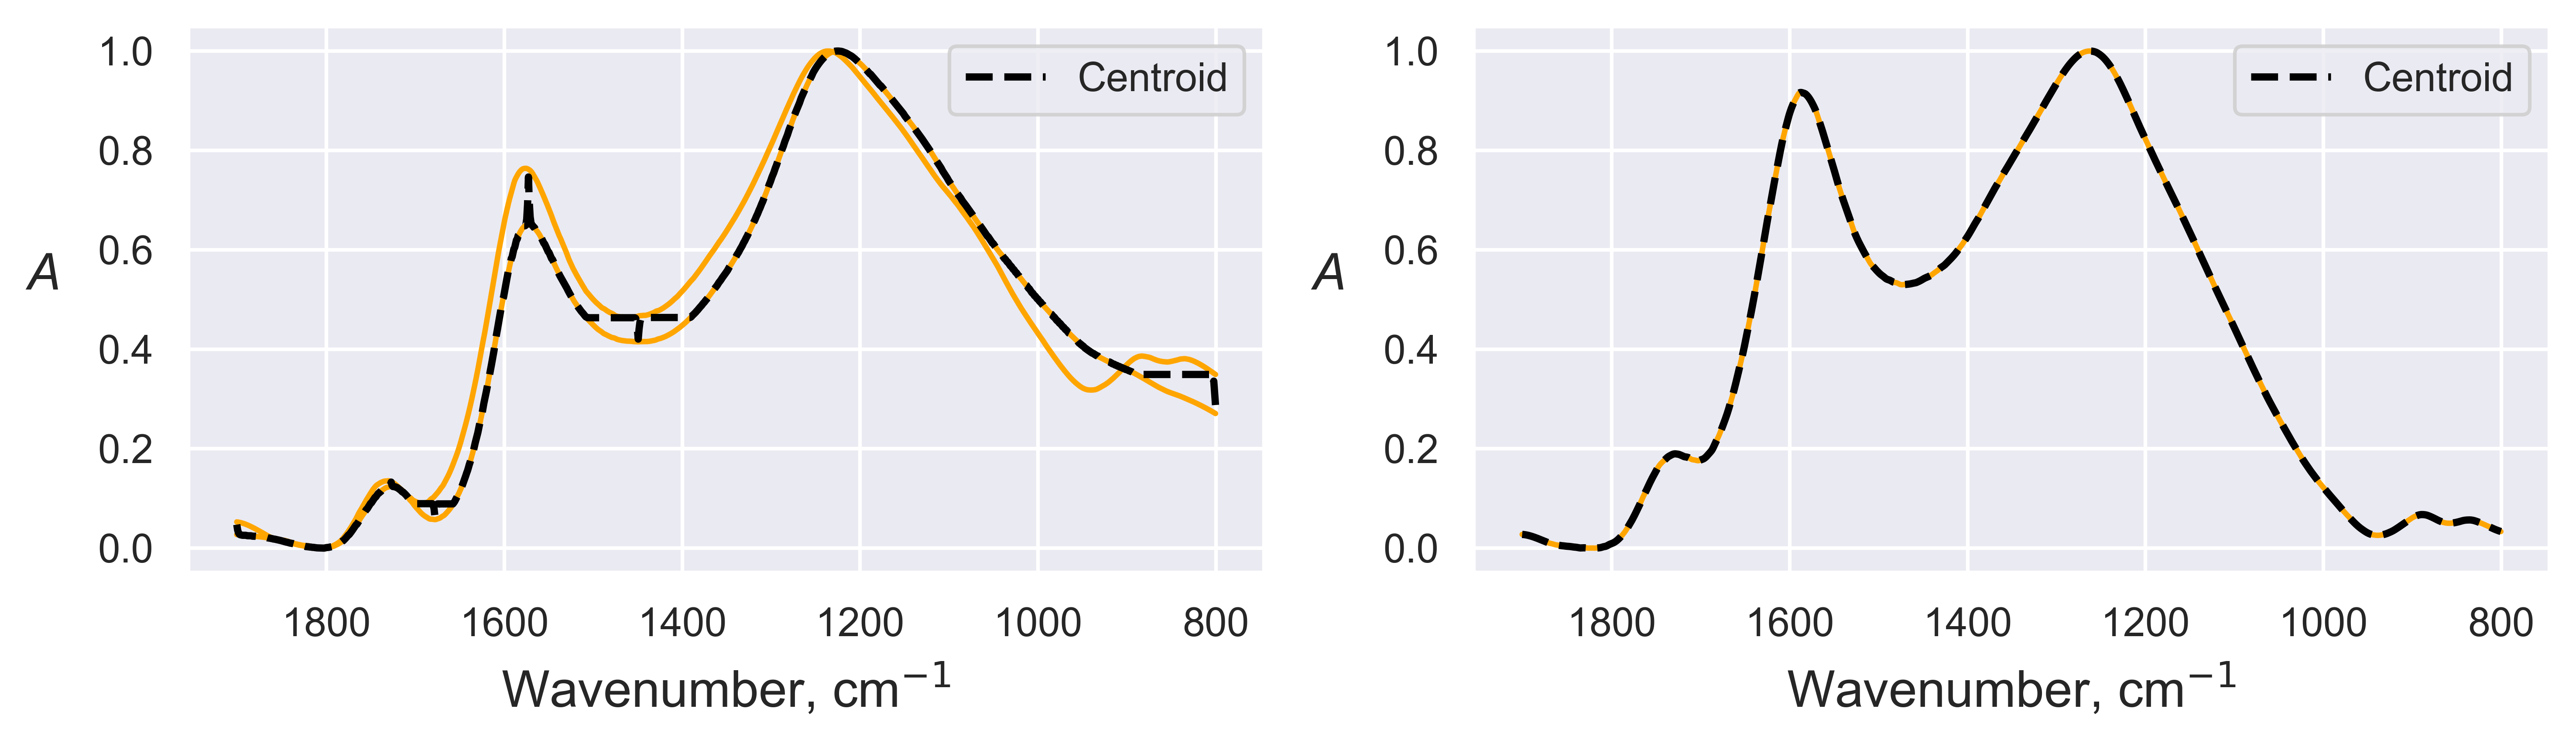

In [86]:
analyzer.get_spectra_clusters_visualization(data=rgo_data, wavenumber=wavenumber, n_clusters=2,
                                            ncols=2, nrows=1, figsize=(10, 3), color='orange',
                                            path_to_save=path_to_save + '/rgo_clusters.png', dpi=600)

### $GO_{d}$

100%|█████████████████████████████████████████████████████████████| 12/12 [07:38<00:00, 38.17s/it]


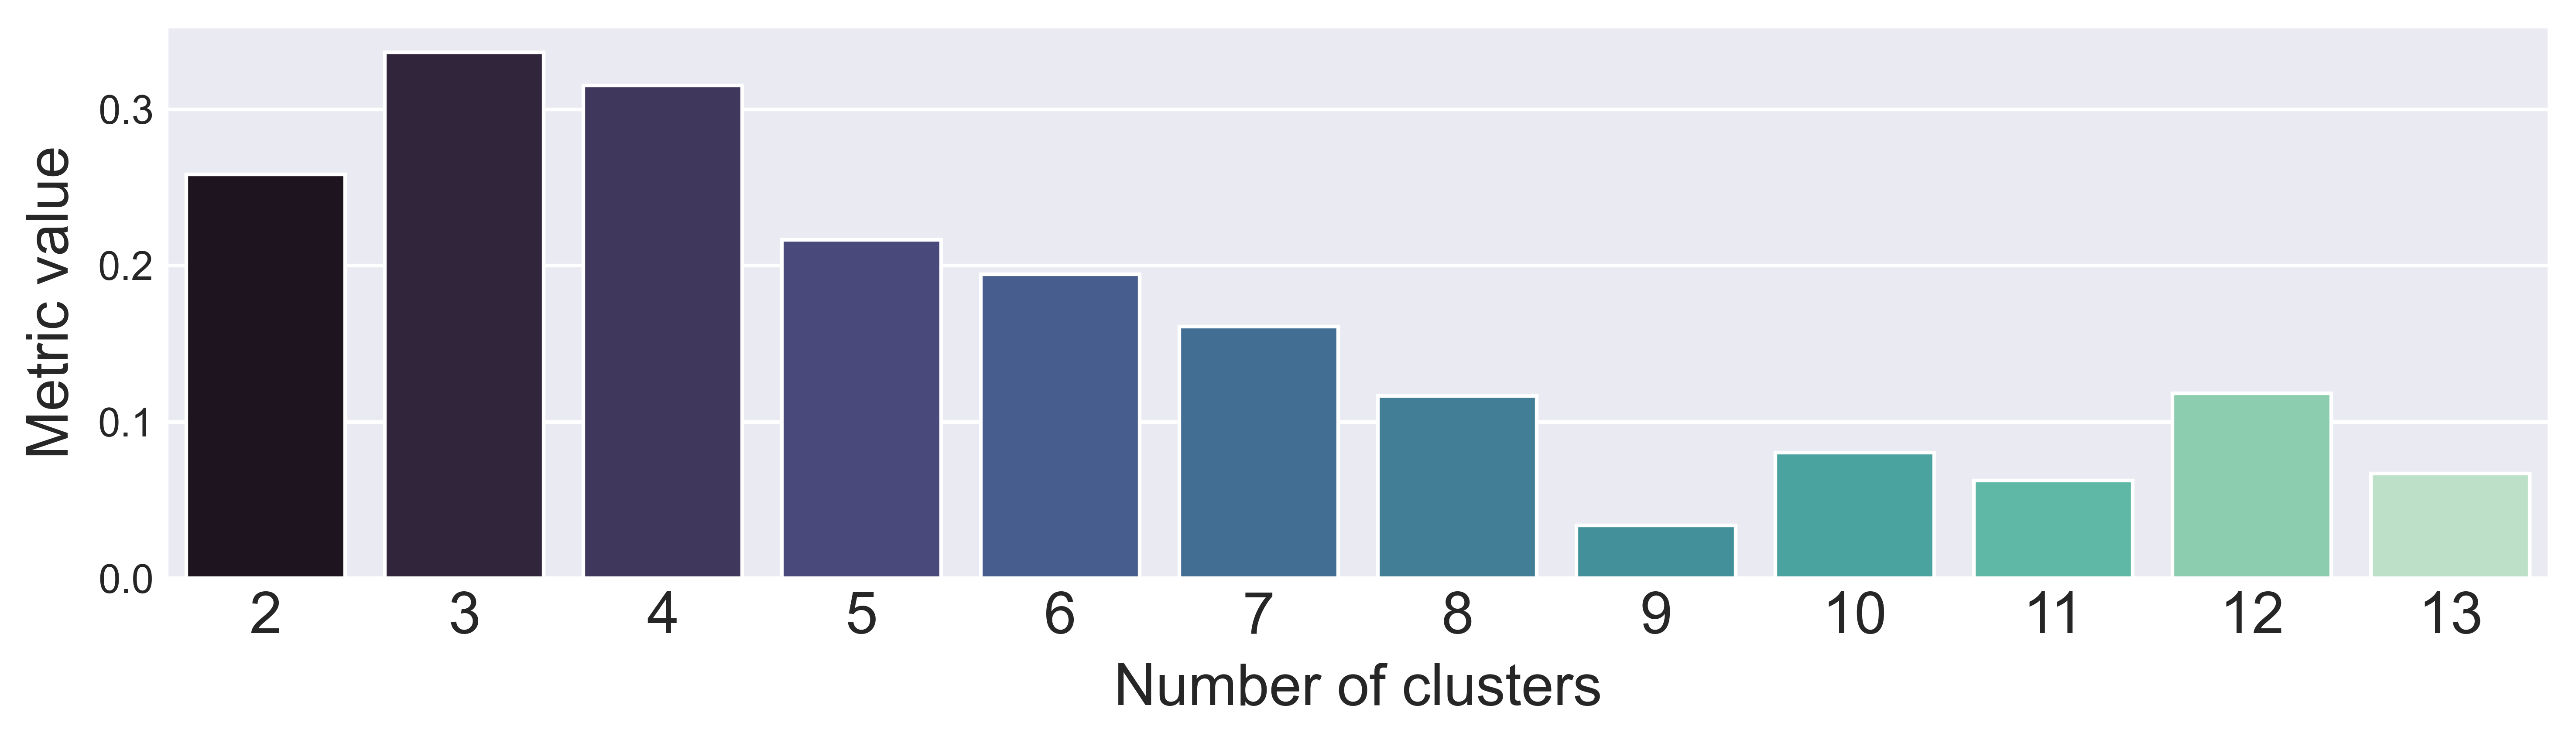

In [87]:
analyzer = ClusterStructureAnalysis(metric='dtw')
analyzer.fit_transform_ts_kmeans(train_data=god_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/god_metrics.png', dpi=600)

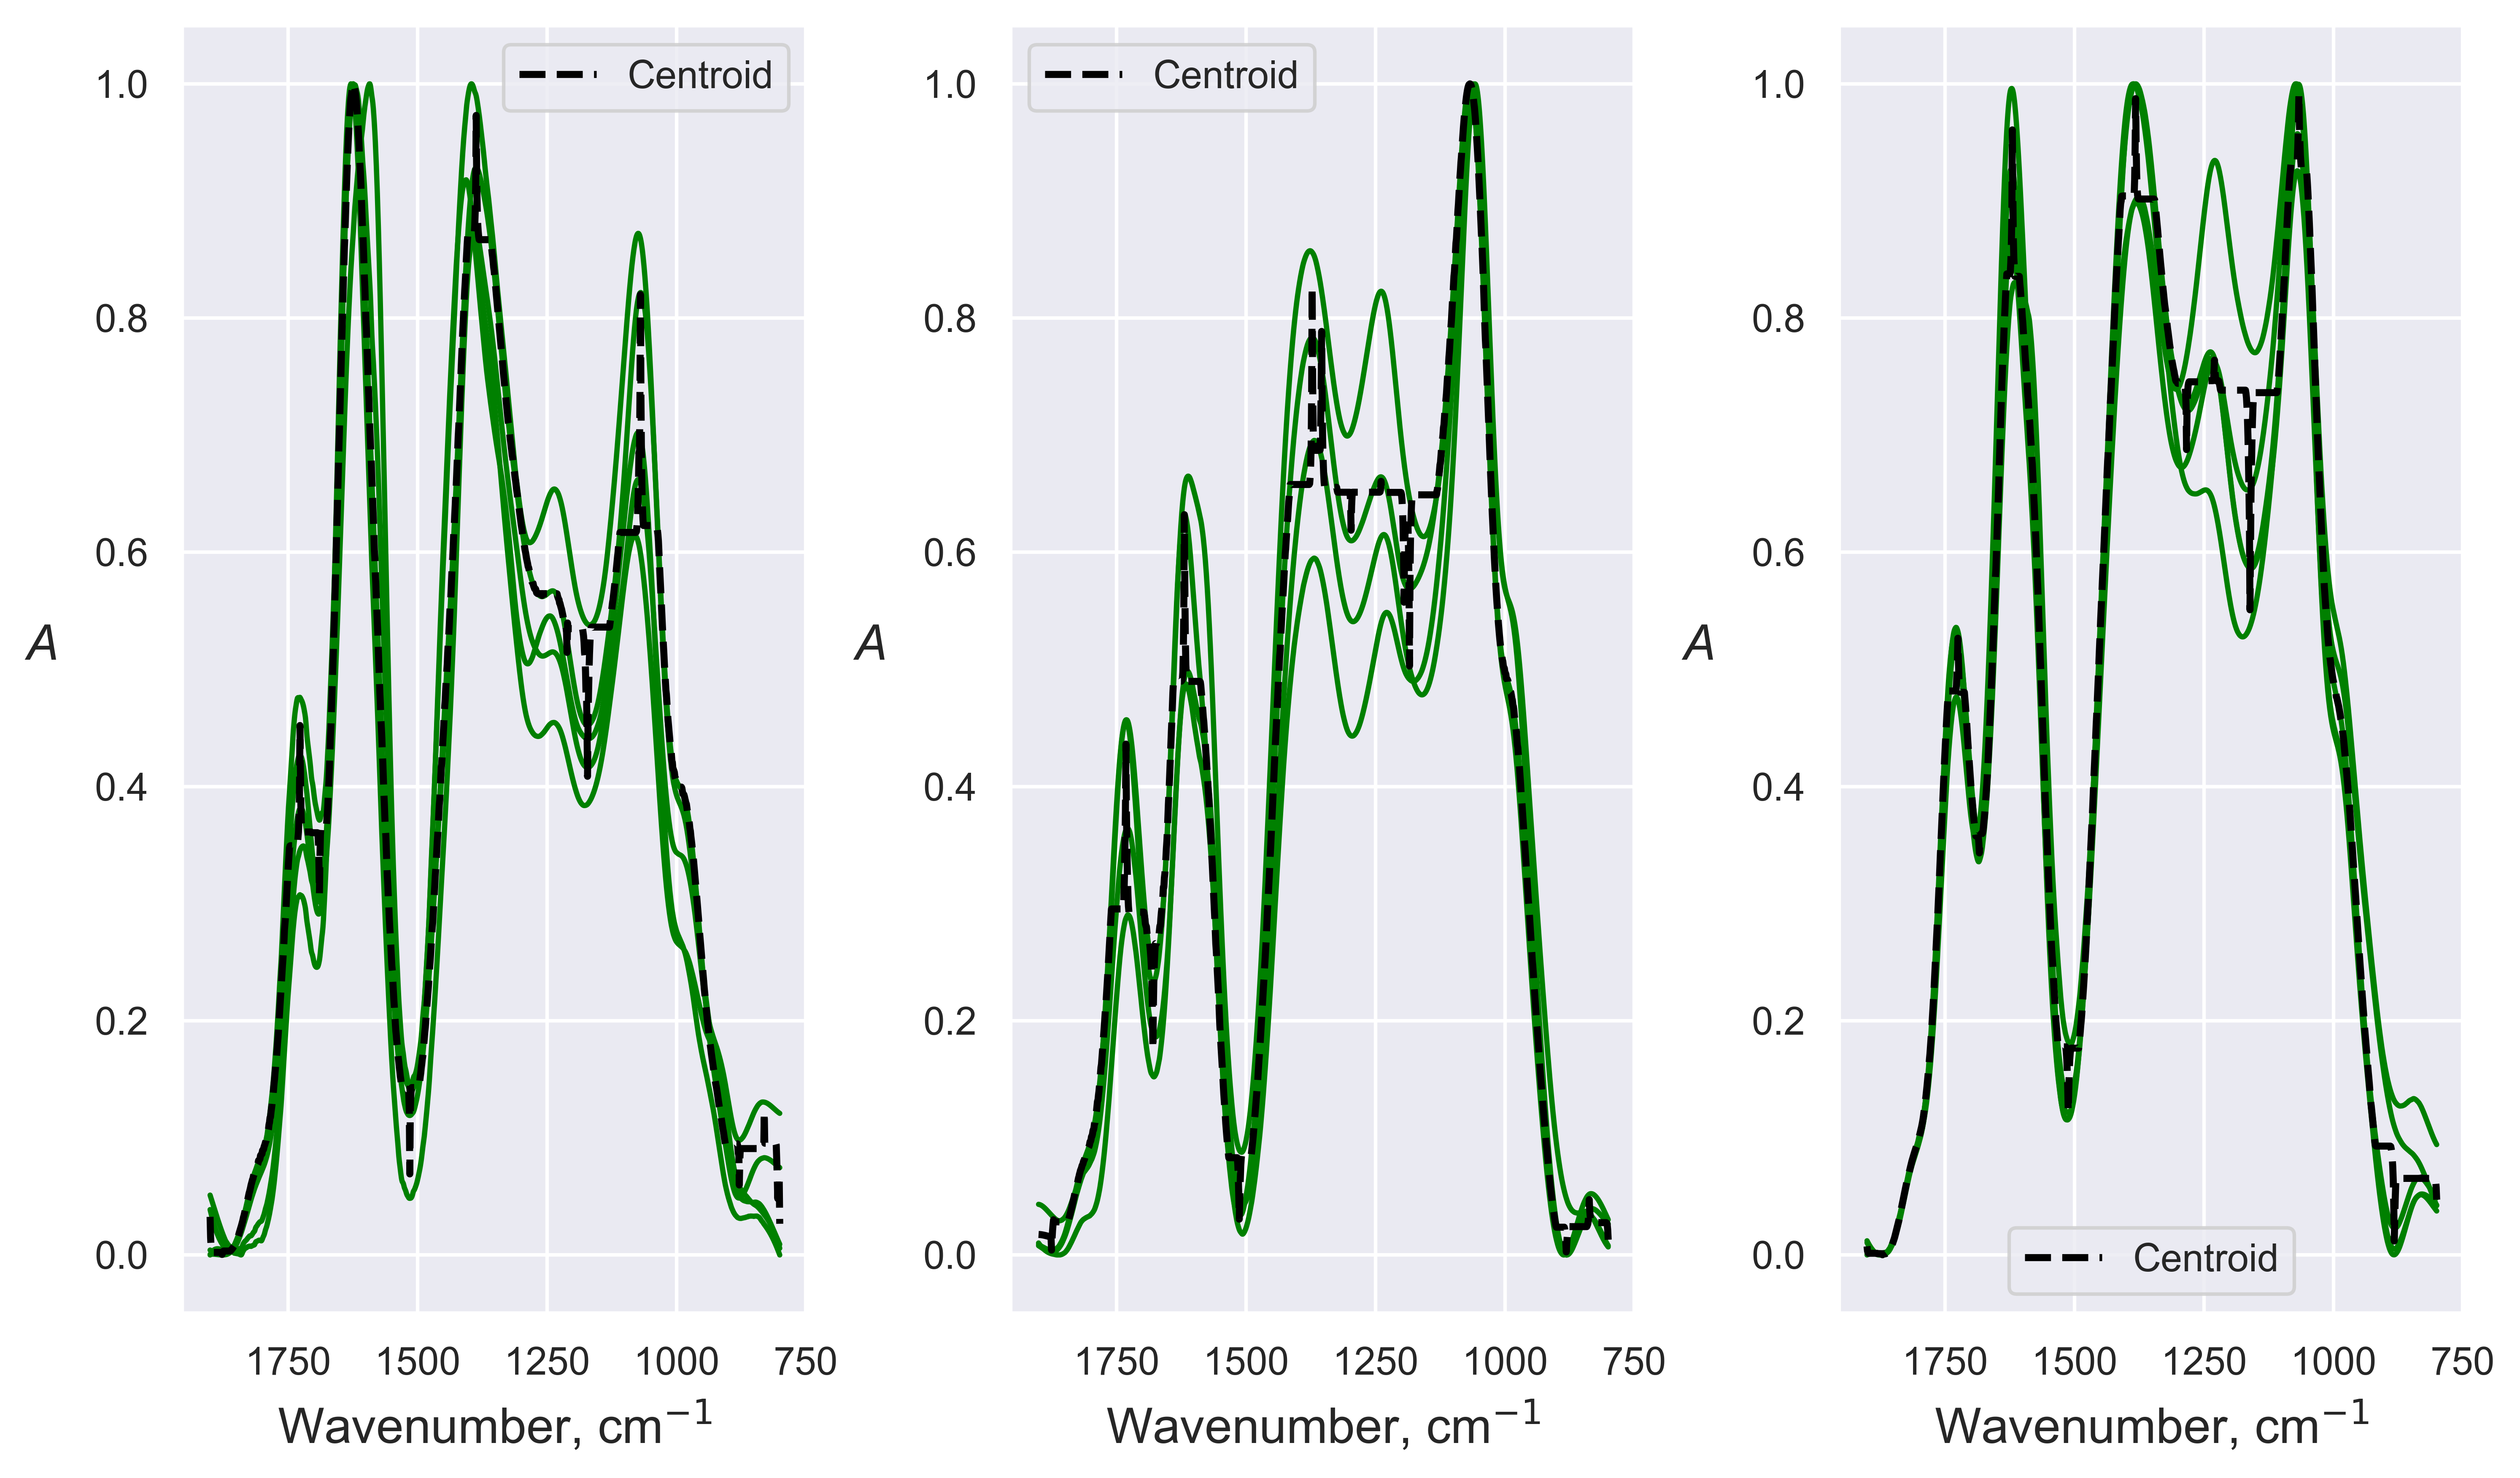

In [90]:
analyzer.get_spectra_clusters_visualization(data=god_data, wavenumber=wavenumber, n_clusters=3,
                                            ncols=3, nrows=1, figsize=(10, 6), color='green',
                                            path_to_save=path_to_save + '/god_clusters_3.png', dpi=600
                                           )